## RAG vs Long Context LLM vs Fine-tuning (DataHack Summit 2024)

## Finetuning LLama-3 on financial Question Answer dataset.



In [1]:
# conda install pytorch-cuda=12.1 pytorch cudatoolkit xformers -c pytorch -c nvidia -c xformers -y

# pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

# !pip install transformers -U

# !pip install --force-reinstall "xformers<0.0.27"

## Goals

**1. To showcase finetuning an LLM is quite easy.**

**2. High quality small dataset is good enough.**

**3. Not always need very large GPUs (LORA+Quantization)**

**4. High Quality and Faster Inference**

### We would be using unsloth to finetune LLama-3 on the custom financial data.

- **Faster finetuning with less VRAM.**
- **Simple and updated with latest LLMs**

In [1]:
from unsloth import FastLanguageModel
import torch
from datasets import load_dataset
import pandas as pd

pd.set_option("display.max_colwidth", 400)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
dataset = load_dataset("adityarane/financial-qa-dataset", split = "train")
dataset_test = load_dataset("adityarane/financial-qa-dataset", split = "test")

In [3]:
pd.DataFrame(dataset).sample(5)

,Questions,Answers,Contexts,Document,Page_no,Year,Sector,Entity,Document_type,Quarter
434,What was the basic earnings per common share for Goldman Sachs in 2022?,$30.42,"\nYear Ended December\nin millions, except per share amounts 2022 2021 2020\nRevenues \nInvestment banking $ 7,360 $ 14,136 $ 9,100 \nInvestment management 9,005 8,171 6,986 \nCommissions and fees 4,034 3,590 3,539 \nMarket making 18,634 15,357 15,428 \nOther principal transactions 654 11,615 4,756 \nTotal non-interest revenues 39,687 52,869 39,809 \nInterest income 29,024 ...",2022-10-k.pdf,page_0,2022,Financial Services,Goldman Sachs,annual report,None
251,How much did Alphabet spend on Research and Development in 2021?,"$31,562 million","Alphabet Inc.\nCONSOLIDATED STATEMENTS OF INCOME\n(In millions, except per share amounts)\n Year Ended December 31,\n 2019 2020 2021\nRevenues $ 161,857 $ 182,527 $ 257,637 \nCosts and expenses:\nCost of revenues 71,896 84,732 110,939 \nResearch and development 26,018 27,573 31,562 \nSales and marketing 18,464 17,946 22,912 \nGeneral and administrative 9,551 11,052 13,510 \nEuropea...",20220202-alphabet-10k.pdf,page_1,2021,Technology,Alphabet,annual report,None
14,"What was the total value of Apple Inc.'s 'Current assets' as of September 30, 2023?","$143,566 million","Apple Inc.\nCONSOLIDATED BALANCE SHEETS\n(In millions, except number of shares, which are reflected in thousands, and par value)\nSeptember 30,\n2023September 24,\n2022\nASSETS:\nCurrent assets:\nCash and cash equivalents $ 29,965 $ 23,646 \nMarketable securities 31,590 24,658 \nAccounts receivable, net 29,508 28,184 \nVendor non-trade receivables 31,477 32,748 \nInventories 6,331 4,94...",_10-K-Q4-2023-As-Filed.pdf,page_2,2023,Technology,Apple,annual report,None
24,What was the net cash provided by operating activities for NVIDIA in 2024?,"$28,090 million","Table of Contents\nNVIDIA Corporation and Subsidiaries\nConsolidated Statements of Cash Flows\n(In millions)\nYear Ended\n Jan 28, 2024 Jan 29, 2023 Jan 30, 2022\nCash flows from operating activities: \nNet income $ 29,760 $ 4,368 $ 9,752 \nAdjustments to reconcile net income to net cash provided by operating activities: \nStock-based compensation expense 3,549 2,709 2,004 \nDepreciation ...",1cbe8fe7-e08a-46e3-8dcc-b429fc06c1a4.pdf,page_4,2023,Technology,Nvidia,annual report,None
310,How much did the change in unrealized gains/losses on marketable debt securities contribute to Apple Inc.'s total other comprehensive income in 2019?,"$3,827 million","Apple Inc.\nCONSOLIDATED STATEMENTS OF COMPREHENSIVE INCOME\n(In millions)\nYears ended\nSeptember 25,\n2021September 26,\n2020September 28,\n2019\nNet income $ 94,680 $ 57,411 $ 55,256 \nOther comprehensive income/(loss):\nChange in foreign currency translation, net of tax 501 88 (408) \nChange in unrealized gains/losses on derivative instruments, net of tax:\nChange in fair value of deriv...",_10-K-2021-(As-Filed).pdf,page_1,2021,Technology,Apple,annual report,None


In [5]:
print(f"Train dataset size: {len(dataset)}")
print(f"Test dataset size: {len(dataset_test)}")

Train dataset size: 475
Test dataset size: 53


### Loading llama-3-8b-Instruct-bnb-4bit model for finetuning

In [5]:
max_seq_length = 2048 # Choose any seq_lenght! Unsloth supports RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use a 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


### Lets create alpaca prompt for each row in Train and Test dataset

In [13]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["Questions"]
    inputs       = examples["Contexts"]
    outputs      = examples["Answers"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


### Other formats for instruction fine-tuning based tasks and LLMs

1. Vicuna:
 
```
### Human:
(Question Text)
### Assistant:
(Response Text)

```



2. Mixtral

```
<s> [INST] Instruction [/INST] Model answer</s> [INST] Follow-up instruction [/INST]
```


Other Formats:
https://github.com/rohan-paul/LLM-Prompt-Formatting-for-finetuning-Inferencing


In [6]:
dataset = dataset.map(formatting_prompts_func, batched = True,)
dataset_test = dataset_test.map(formatting_prompts_func, batched = True,)


In [7]:
pd.DataFrame(dataset)[["Questions", "Answers", "Contexts", "text"]].head(1)

,Questions,Answers,Contexts,text
0,What was the Accumulated other comprehensive income/(loss) for Goldman Sachs at the beginning of 2021?,"($1,434) million","Year Ended December\n$ in millions 2022 2021 2020\nPreferred stock \nBeginning balance $ 10,703 $ 11,203 $ 11,203 \nIssued – 2,175 350 \nRedeemed – (2,675) (350) \nEnding balance 10,703 10,703 11,203 \nCommon stock \nBeginning balance 9 9 9 \nIssued – – – \nEnding balance 9 9 9 \nShare-based awards \nBeginning balance 4,211 3,468 3,195 \nIssuance and amortization of ...","Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat was the Accumulated other comprehensive income/(loss) for Goldman Sachs at the beginning of 2021?\n\n### Input:\nYear Ended December\n$ in millions 2022 2021 2020\nPreferred stock \nBeginning balance $ 10,703..."


### PEFT Finetuning using LORA. 
In PEFT we only fine-tune a small number of (extra) model parameters while freezing most parameters of the pretrained LLMs.
It injects trainable rank decomposition matrices into each layer of the Transformer architecture. [https://arxiv.org/pdf/2106.09685]


ΔW is the weight update for an A × B weight matrix. Then, we can decompose the weight update matrix into two smaller matrices: ΔW = WA WB, where WA is an an A × r-dimensional matrix, and WB is an an r × B-dimensional matrix. [https://lightning.ai/pages/community/article/lora-llm/]

In [8]:
from IPython.display import display, HTML, Image
display(Image(url='https://lightningaidev.wpengine.com/wp-content/uploads/2023/04/lora-4-300x226@2x.png', width=400, unconfined=True))

In [9]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128. (Lower rank fast/efficient while limited capability)
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # all are linear layers.
    lora_alpha = 16, # model's ability to adapt to the specific task. Combination of data size and lora_alpha to tune for.
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ: https://arxiv.org/pdf/2310.08659
)

Unsloth 2024.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [10]:
from IPython.display import display, HTML, Image
display(Image(url='https://cdn.analyticsvidhya.com/wp-content/uploads/2023/07/Screenshot-2023-07-03-230612.png', width=600, unconfined=True))

### SFT is First Stage of Finetuning

In [11]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # multiple short examples are packed in the same input sequence. Can make training 5x faster for short sequences. 
    args = TrainingArguments(
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 2,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    )
)

max_steps is given, it will override any value given in num_train_epochs


In [12]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.168 GB.
5.594 GB of memory reserved.


### Finetuning Starts...

In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 475 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 2
\        /    Total batch size = 32 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.867100
2,1.784000
3,1.883100
4,1.789300
5,1.632300
6,1.697500
7,1.738100
8,1.567000
9,1.490500
10,1.416400


## Inference

In [14]:
model.save_pretrained("llama-3-8b-fin-qa-29jul") # Local saving
tokenizer.save_pretrained("llama-3-8b-fin-qa-29jul")

('llama-3-8b-fin-qa-29jul/tokenizer_config.json',
 'llama-3-8b-fin-qa-29jul/special_tokens_map.json',
 'llama-3-8b-fin-qa-29jul/tokenizer.json')

In [1]:
# model.push_to_hub("akgeni/llama-3-8b-fin-qa-29jul", token = "") # Online saving
# tokenizer.push_to_hub("akgeni/llama-3-8b-fin-qa-29jul", token = "") # Online saving

In [16]:
dataset_test[0]

{'Questions': 'What was the total revenue generated by NVIDIA  Corporation in the year ended Jan 29, 2023?',
 'Answers': '$26,974 million',
 'Contexts': 'Table of Contents\nNVIDIA  Corporation and Subsidiaries\nConsolidated Statements of Income\n(In millions, except per share data)\nYear Ended\nJan 28, 2024 Jan 29, 2023 Jan 30, 2022\nRevenue $ 60,922 $ 26,974 $ 26,914 \nCost of revenue 16,621 11,618 9,439 \nGross profit 44,301 15,356 17,475 \nOperating expenses    \nResearch and development 8,675 7,339 5,268 \nSales, general and administrative 2,654 2,440 2,166 \nAcquisition termination cost — 1,353 — \nTotal operating expenses 11,329 11,132 7,434 \nOperating income 32,972 4,224 10,041 \nInterest income 866 267 29 \nInterest expense (257) (262) (236)\nOther , net 237 (48) 107 \nOther income (expense), net 846 (43) (100)\nIncome before income tax 33,818 4,181 9,941 \nIncome tax expense (benefit) 4,058 (187) 189 \nNet income $ 29,760 $ 4,368 $ 9,752 \nNet income per share:\nBasic $ 12.05

### Evaluation

In [14]:
from datasets import load_dataset

dataset_test = load_dataset("adityarane/financial-qa-dataset", split = "test")
dataset_test = dataset_test.map(formatting_prompts_func, batched = True,)

In [24]:
dataset_test

Dataset({
    features: ['Questions', 'Answers', 'Contexts', 'Document', 'Page_no', 'Year', 'Sector', 'Entity', 'Document_type', 'Quarter', 'text'],
    num_rows: 53
})

In [11]:
import re
pattern = r'### Response:(.*?)<\|eot_id\|>'
def extract_output(text):
    text = text.replace("\n", "")
    #print(text)
    match = re.search(pattern, text)
    if match:
        #print(match.group(1))
        return match.group(1)
    else:
        print("No matching pattern found")
        return "NO OUTPUT"

In [10]:
from unsloth import FastLanguageModel
max_seq_length = 2048 # Choose any seq_lenght! Unsloth supports RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use a 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "llama-3-8b-fin-qa-29jul", # Load Finetuned model.
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = True
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

predictions = []

for d in dataset_test:
    inputs = tokenizer(
    [
        alpaca_prompt.format(
            d["Questions"], # instruction
            d["Contexts"], # input
            "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
    gen_outputs = tokenizer.batch_decode(outputs)

    out = extract_output(gen_outputs[0])
    predictions.append(out)
    

==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [15]:
dataset_test = dataset_test.add_column("predictions", predictions)

In [16]:
dataset_test_df = pd.DataFrame(dataset_test)

In [17]:
dataset_test_df[["Questions", "Answers", "predictions"]]

,Questions,Answers,predictions
0,"What was the total revenue generated by NVIDIA Corporation in the year ended Jan 29, 2023?","$26,974 million","$26,974 million"
1,"What were the actuarial gains/losses from pensions and similar obligations, after tax, for Mercedes-Benz Group in 2022?","2,318 million euros","€2,318 million"
2,How much did Alphabet Inc. make in sales and marketing in 2023?,"$27,917 million","$27,917 million"
3,How much did Apple Inc. spend on Research and Development in 2020?,"$18,752 million","$18,752 million"
4,"What was the total shareholders' equity of NVIDIA Corporation as of January 31, 2021?","$16,893 million","$16,893 million"
5,"What was the value of Alphabet's total liabilities as of December 31, 2021?","$107,633 million","$107,633 million"
6,How much income tax did the BMW Group pay in 2020?,"€1,605 million","€1,605 million"
7,"In 2021, what was the total other comprehensive income/(loss) for Apple Inc., excluding the impact of derivative instruments?",($466) million,$569 million
8,What was the value of Goldman Sachs's 'Cash and cash equivalents' in 2023?,"$241,577 million","$241,577 million"
9,How much did Alphabet Inc. gain or lose from available-for-sale investments (net change) in 2020?,$800 million,"$1,500 million"


### Comparison of Finetuned LLM vs Base LLM

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-l564{border-color:inherit;font-family:"Lucida Console", Monaco, monospace !important;font-size:18px;text-align:center;
  vertical-align:top}
.tg .tg-54m6{border-color:inherit;font-family:"Lucida Console", Monaco, monospace !important;font-size:18px;text-align:left;
  vertical-align:top}
.tg .tg-dvpl{border-color:inherit;text-align:right;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-0lax"></th>
    <th class="tg-l564"><span style="font-weight:bold">Base LLM</span></th>
    <th class="tg-54m6"><span style="font-weight:bold">Finetuned LLM</span></th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-0lax"><span style="font-weight:bold">Accuracy</span></td>
    <td class="tg-c3ow">69.81%</td>
    <td class="tg-c3ow">71.69%</td>
  </tr>
  <tr>
    <td class="tg-0lax"><span style="font-weight:bold">Output</span><br></td>
    <td class="tg-dvpl"><br>According to the provided table, NVIDIA Corporation\'s total revenue for the year ended Jan 29, 2023, was \$26,974 million.</td>
    <td class="tg-c3ow">$26,974 million</td>
  </tr>
  <tr>
    <td class="tg-0lax"><span style="font-weight:bold">Precision </span></td>
    <td class="tg-0pky">Low precision and Verbose Output.<br>Post Processing Needed. <br>Less actionable.</td>
    <td class="tg-0pky">Highly precise output. <br>Minimal or no Post processing needed.<br>Actionable Output.<br></td>
  </tr>
</tbody></table>

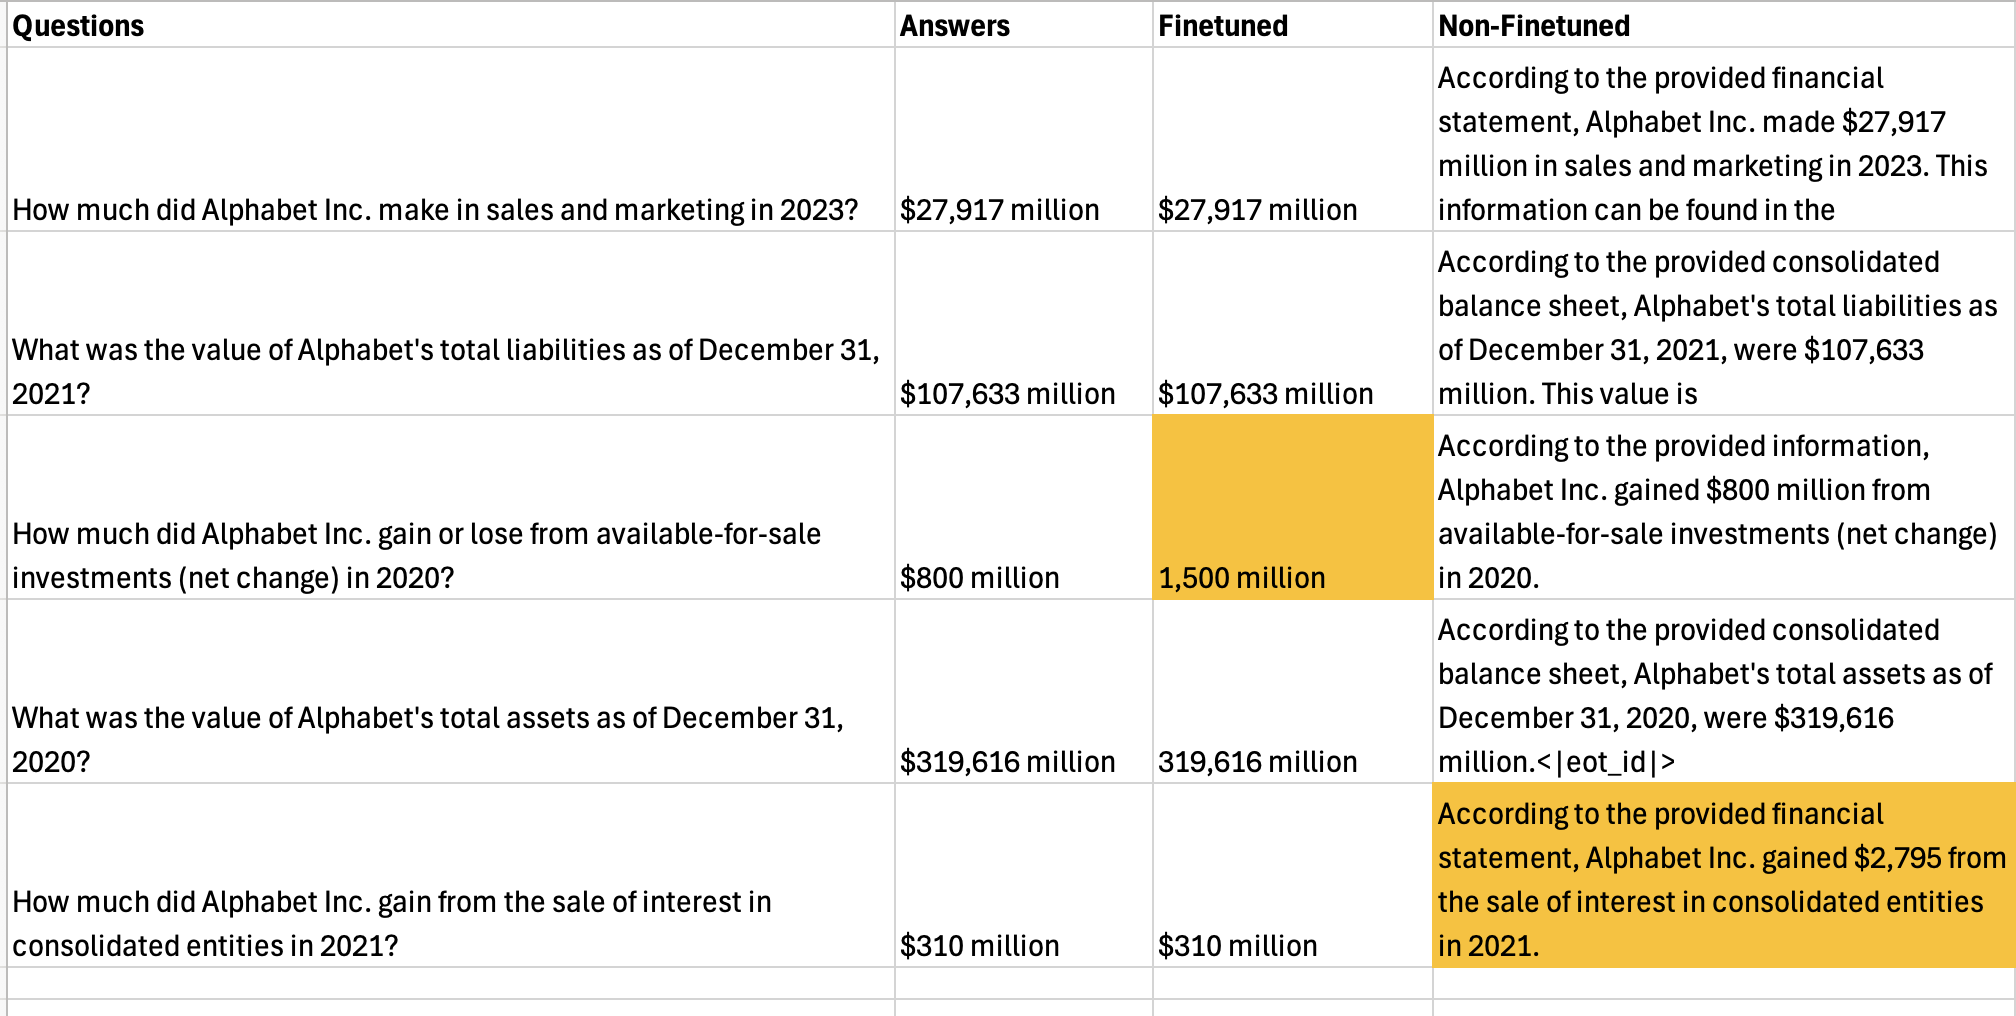

In [6]:
from IPython.display import Image
Image(filename="finetuned-vs-nonfinetuned.png")

## Link to Github

<img src="images/av-hack-panel-finetuning.png" alt="Drawing" style="width: 400px;"/>